In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Loading data

In [2]:
df = pd.read_csv("points.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14552286 entries, 0 to 14552285
Data columns (total 21 columns):
 #   Column             Dtype  
---  ------             -----  
 0   X                  float64
 1   Y                  float64
 2   Z                  float64
 3   Intensity          int64  
 4   ReturnNumber       int64  
 5   NumberOfReturns    int64  
 6   ScanDirectionFlag  int64  
 7   EdgeOfFlightLine   int64  
 8   Classification     int64  
 9   ScanAngleRank      float64
 10  UserData           int64  
 11  PointSourceId      int64  
 12  Synthetic          int64  
 13  KeyPoint           int64  
 14  Withheld           int64  
 15  Overlap            int64  
 16  ScannerChannel     int64  
 17  GpsTime            float64
 18  Red                int64  
 19  Green              int64  
 20  Blue               int64  
dtypes: float64(5), int64(16)
memory usage: 2.3 GB


In [4]:
df.head(10)

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,...,PointSourceId,Synthetic,KeyPoint,Withheld,Overlap,ScannerChannel,GpsTime,Red,Green,Blue
0,568770.91,243778.52,203.67,318,2,2,0,0,0,13.002,...,52,0,0,0,1,0,3.782114e+08,8448,20480,34816
1,568777.43,243778.65,203.75,424,1,1,0,0,0,13.002,...,52,0,0,0,1,0,3.782114e+08,7424,12288,20480
2,568789.02,243778.79,203.37,1026,1,1,0,0,2,13.002,...,52,0,0,0,0,0,3.782114e+08,10496,10752,15872
3,568835.44,243778.81,201.33,2454,1,1,0,0,0,13.002,...,52,0,0,0,1,0,3.782114e+08,13568,18432,26880
4,568831.66,243779.33,201.33,2632,1,1,0,0,0,13.002,...,52,0,0,0,1,0,3.782114e+08,14592,19456,27136
5,568849.80,243779.66,201.26,2442,1,1,0,0,0,12.000,...,52,0,0,0,1,0,3.782114e+08,52992,50944,48128
6,568854.47,243779.47,201.30,2587,1,1,0,0,0,13.002,...,52,0,0,0,1,0,3.782114e+08,50944,47872,44288
7,568860.63,243779.15,201.23,2405,1,1,0,0,0,13.002,...,52,0,0,0,1,0,3.782114e+08,55040,52992,47616
8,568862.66,243779.59,201.20,2669,1,1,0,0,0,13.002,...,52,0,0,0,1,0,3.782114e+08,56576,54784,49920
9,568878.90,243779.96,202.41,470,1,2,0,0,0,13.002,...,52,0,0,0,0,0,3.782114e+08,47360,45312,41984


# Data cleaning and feature engineering

The file contains points belonging to 8 groups:

0 - points processed but unclassified,

2 - points lying on the ground,

3 - points representing low vegetation, i.e., in the range of 0-0.40 m,

4 - points representing medium vegetation, i.e., in the range of 0.40-2.00 m,

5 - points representing tall vegetation, i.e., in the range above 2.00 m,

6 - points representing buildings, structures, and engineering structures,

7 - noise,

9 - points representing water areas.

The first group will be removed from the analysis because these are unclassifiable points.

In [5]:
df.Classification.value_counts()

Classification
0    5114459
2    3840862
5    3292986
6    1865260
4     225775
3     204713
9       7143
7       1088
Name: count, dtype: int64

In [6]:
df = df.drop(df[df.Classification == 0].index)

In [7]:
df.Classification.value_counts()

Classification
2    3840862
5    3292986
6    1865260
4     225775
3     204713
9       7143
7       1088
Name: count, dtype: int64

In [8]:
df.describe()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,...,PointSourceId,Synthetic,KeyPoint,Withheld,Overlap,ScannerChannel,GpsTime,Red,Green,Blue
count,9.437827e+06,9.437827e+06,9.437827e+06,9.437827e+06,9.437827e+06,9.437827e+06,9.437827e+06,9437827.0,9.437827e+06,9.437827e+06,...,9.437827e+06,9437827.0,9437827.0,9437827.0,9437827.0,9437827.0,9.437827e+06,9.437827e+06,9.437827e+06,9.437827e+06
mean,5.690725e+05,2.435335e+05,2.102324e+02,1.758554e+03,1.438846e+00,1.840648e+00,5.047698e-01,0.0,3.912697e+00,-3.508482e+00,...,2.437961e+01,0.0,0.0,0.0,0.0,0.0,3.782124e+08,2.303601e+04,2.486009e+04,2.228370e+04
std,1.663630e+02,1.375317e+02,9.808286e+00,1.293029e+03,8.171432e-01,1.143794e+00,4.999773e-01,0.0,1.673722e+00,3.400788e+00,...,5.263087e-01,0.0,0.0,0.0,0.0,0.0,2.992114e+02,1.517199e+04,1.428945e+04,1.359296e+04
min,5.687645e+05,2.431999e+05,1.905900e+02,1.290000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.0,2.000000e+00,-1.200000e+01,...,2.400000e+01,0.0,0.0,0.0,0.0,0.0,3.782114e+08,0.000000e+00,2.304000e+03,0.000000e+00
25%,5.689296e+05,2.434318e+05,2.024400e+02,7.090000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.0,2.000000e+00,-6.000000e+00,...,2.400000e+01,0.0,0.0,0.0,0.0,0.0,3.782121e+08,9.728000e+03,1.228800e+04,1.152000e+04
50%,5.690898e+05,2.435259e+05,2.062100e+02,1.488000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.0,5.000000e+00,-4.002000e+00,...,2.400000e+01,0.0,0.0,0.0,0.0,0.0,3.782122e+08,1.996800e+04,2.329600e+04,1.817600e+04
75%,5.692215e+05,2.436457e+05,2.168400e+02,2.599000e+03,2.000000e+00,2.000000e+00,1.000000e+00,0.0,5.000000e+00,0.000000e+00,...,2.500000e+01,0.0,0.0,0.0,0.0,0.0,3.782128e+08,3.276800e+04,3.404800e+04,3.097600e+04
max,5.693310e+05,2.437858e+05,2.940100e+02,6.553500e+04,5.000000e+00,5.000000e+00,1.000000e+00,0.0,9.000000e+00,1.300200e+01,...,5.200000e+01,0.0,0.0,0.0,0.0,0.0,3.782128e+08,6.528000e+04,6.528000e+04,6.528000e+04


Columns that do not contribute to the model and contain only a single value ("EdgeOfFlightLine", "UserData", "Synthetic", "KeyPoint", "Withheld", "Overlap", "ScannerChannel") will also be removed from the analysis.

The data also includes RGB values ​​(corresponding to the colors Red, Green, and Blue) obtained from aerial imagery, which will also be removed because the model is designed to classify points based solely on LIDAR data.

In [9]:
df = df.drop(["EdgeOfFlightLine", "UserData", "Synthetic", "KeyPoint", "Withheld","Overlap", "ScannerChannel", "Red", "Green", "Blue"], axis=1)

In [10]:
df.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,Classification,ScanAngleRank,PointSourceId,GpsTime
2,568789.02,243778.79,203.37,1026,1,1,0,2,13.002,52,3.782114e+08
12,568919.79,243779.63,204.53,568,1,1,0,6,13.002,52,3.782114e+08
16,568982.16,243781.35,205.39,566,2,3,1,5,13.002,52,3.782114e+08
20,568946.98,243780.27,203.81,2480,1,1,0,4,13.002,52,3.782114e+08
23,569016.73,243781.60,202.07,191,4,4,1,2,12.000,52,3.782114e+08


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9437827 entries, 2 to 14552283
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   X                  float64
 1   Y                  float64
 2   Z                  float64
 3   Intensity          int64  
 4   ReturnNumber       int64  
 5   NumberOfReturns    int64  
 6   ScanDirectionFlag  int64  
 7   Classification     int64  
 8   ScanAngleRank      float64
 9   PointSourceId      int64  
 10  GpsTime            float64
dtypes: float64(5), int64(6)
memory usage: 864.1 MB


Features that will be used in the project:

- XYZ - position of a point in XYZ space
- Intensity – the strength of the pulse returned to the sensor. Values range from 1 to 256. They provide information about the surface that reflected the light pulse. The higher the value, the more light was reflected.
- Return Number - the number of times a laser pulse returns. A light pulse sent from a lidar scanner can return to the sensor multiple times. The pulse can partially reflect off an object and then return to the scanner, with part of the pulse still hitting another object or surface. This occurs when there are overlapping layers of objects or structures, such as vegetation.
- Number Of Returns -  the total number of turns for a given pulse.
- Scan Direction Flag - a value that specifies the direction the scanner was moving when the return pulse was emitted.
- Scan Angle Rank - the angle at which the pulse was emitted.
- Point Source ID - the identifier for a group of data from a single flight line or from an entire flight path.
- GPS Time - the time recorded at the moment the on-board GPS system emits the sensor pulse.

# Models
Creation of machine learning models (Regression, Decision Tree Classifier, Naive Bayes, Random Forest Classifier) and those using neural networks.

## Division of the data set

In [12]:
X = df.drop(["Classification"], axis=1)
y= df["Classification"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Logistic regresion

In [13]:
model = LogisticRegression(multi_class='ovr')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       0.66      0.76      0.71   1267102
           3       0.00      0.00      0.00     67584
           4       0.00      0.00      0.00     74507
           5       0.64      0.78      0.71   1087058
           6       0.41      0.22      0.29    615485
           7       0.00      0.00      0.00       369
           9       0.00      0.00      0.00      2378

    accuracy                           0.63   3114483
   macro avg       0.24      0.25      0.24   3114483
weighted avg       0.57      0.63      0.59   3114483



In [14]:
print(accuracy_score(y_test, y_pred))

0.6265537490492001


The confusion matrix shows how many labels were classified correctly and how many incorrectly. 
The first matrix shows the quantity, while the second shows the precision.

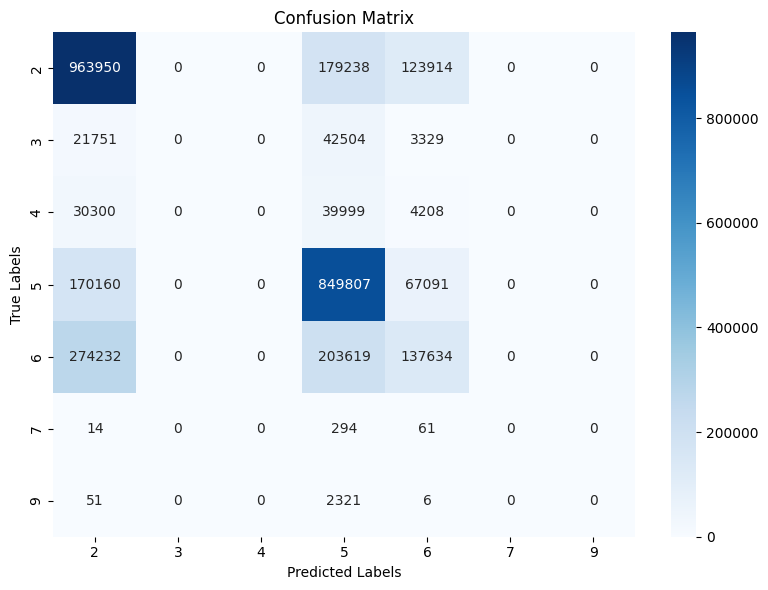

In [15]:
classes = [2, 3, 4, 5, 6, 7, 9]
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

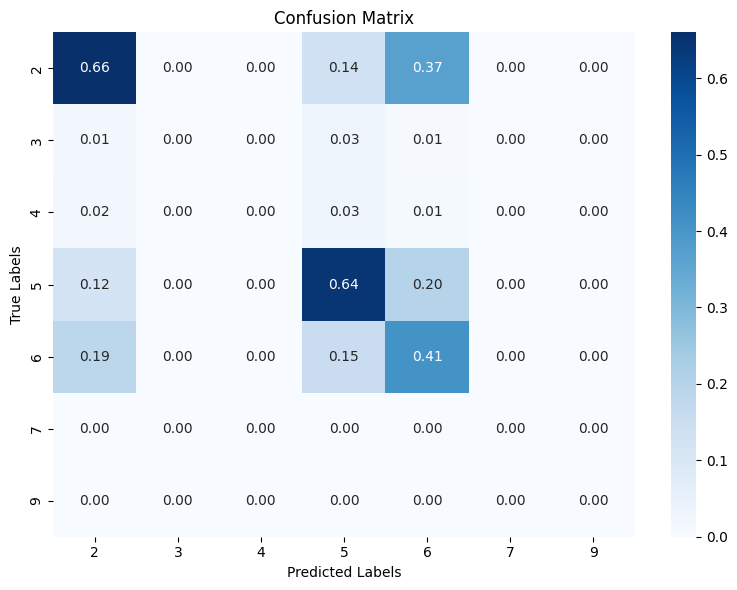

In [16]:
classes = [2, 3, 4, 5, 6, 7, 9]
cm = confusion_matrix(y_test, y_pred, normalize='pred')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## DecisionTreeClassifier

In [17]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       0.89      1.00      0.94   1267102
           3       0.00      0.00      0.00     67584
           4       0.52      0.16      0.24     74507
           5       0.82      0.91      0.86   1087058
           6       0.82      0.62      0.70    615485
           7       0.00      0.00      0.00       369
           9       0.00      0.00      0.00      2378

    accuracy                           0.85   3114483
   macro avg       0.44      0.38      0.39   3114483
weighted avg       0.82      0.85      0.83   3114483



In [18]:
print(accuracy_score(y_test, y_pred))

0.8491817100944201


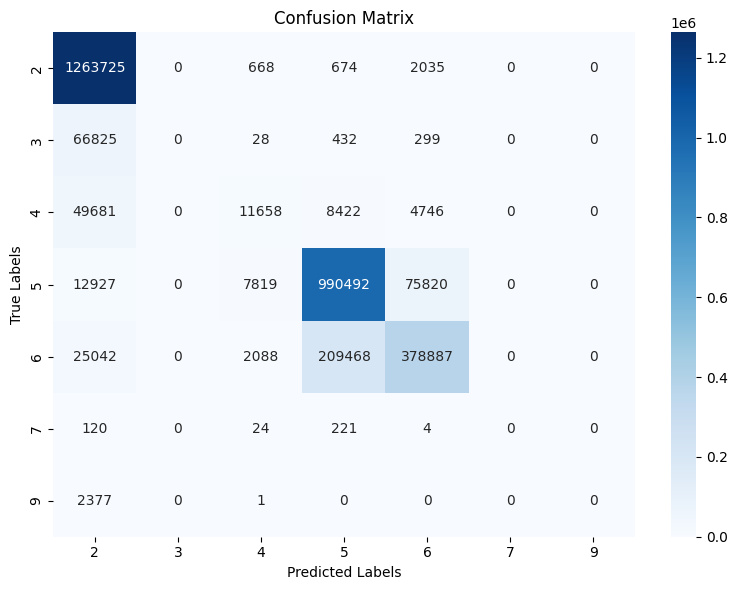

In [19]:
classes = [2, 3, 4, 5, 6, 7, 9]
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

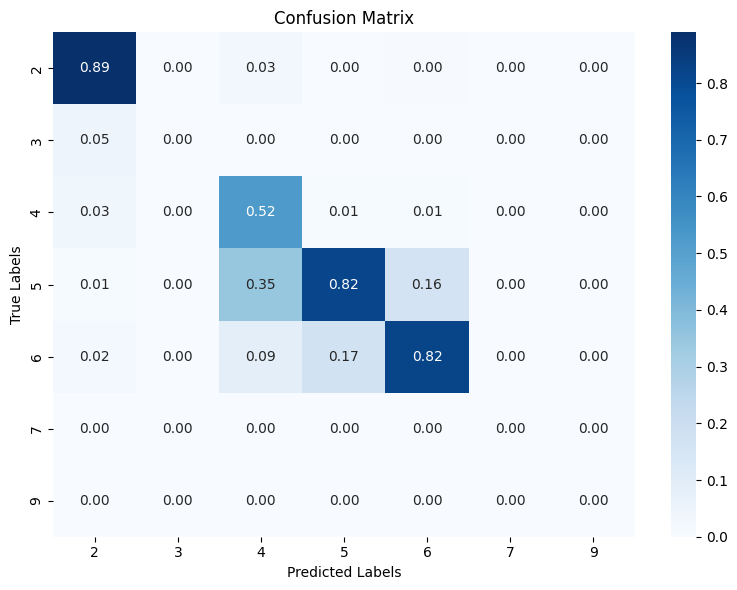

In [20]:
classes = [2, 3, 4, 5, 6, 7, 9]
cm = confusion_matrix(y_test, y_pred, normalize='pred')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Naive Bayes

In [21]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       0.91      0.93      0.92   1267102
           3       0.29      0.29      0.29     67584
           4       0.12      0.04      0.06     74507
           5       0.84      0.81      0.83   1087058
           6       0.72      0.78      0.75    615485
           7       0.00      0.00      0.00       369
           9       0.14      0.99      0.24      2378

    accuracy                           0.82   3114483
   macro avg       0.43      0.55      0.44   3114483
weighted avg       0.81      0.82      0.82   3114483



In [22]:
print(accuracy_score(y_test, y_pred))

0.8213966812469357


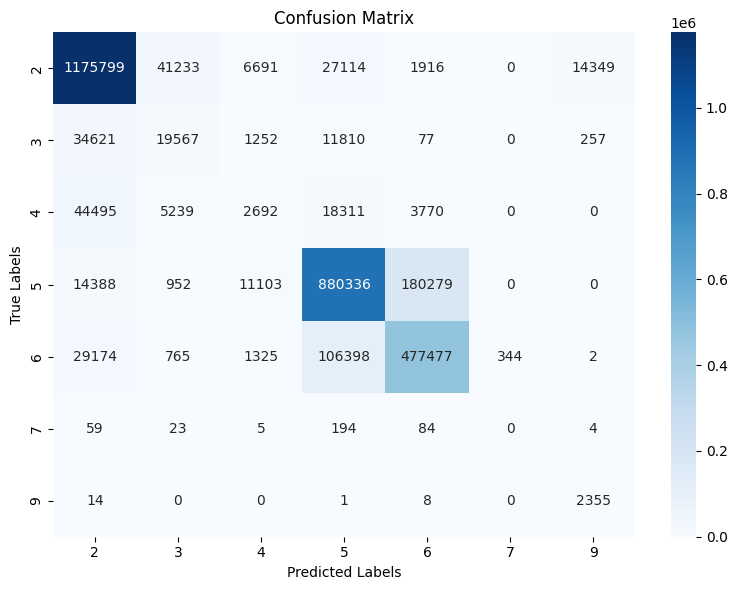

In [23]:
classes = [2, 3, 4, 5, 6, 7, 9]
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

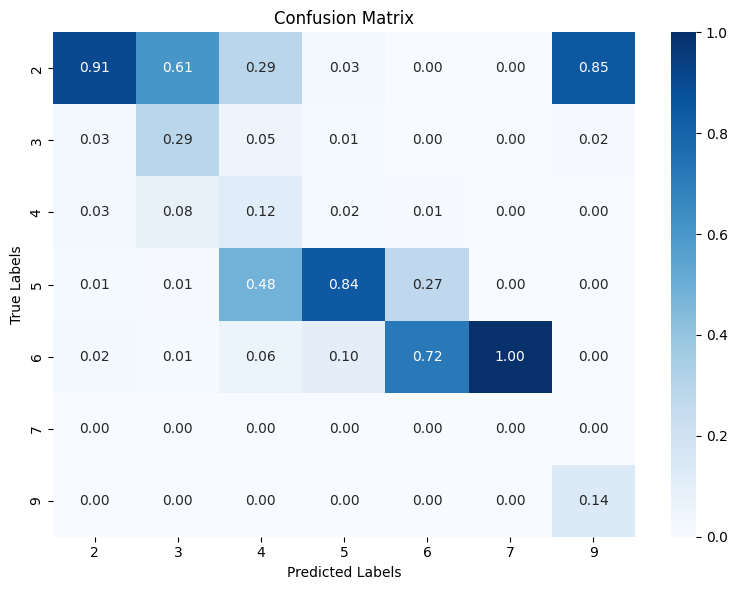

In [24]:
classes = [2, 3, 4, 5, 6, 7, 9]
cm = confusion_matrix(y_test, y_pred, normalize='pred')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## RandomForestClassifier

In [25]:
model = RandomForestClassifier(max_depth=3, n_estimators=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       0.88      1.00      0.93   1267102
           3       0.00      0.00      0.00     67584
           4       0.00      0.00      0.00     74507
           5       0.84      0.92      0.88   1087058
           6       0.85      0.66      0.74    615485
           7       0.00      0.00      0.00       369
           9       0.00      0.00      0.00      2378

    accuracy                           0.86   3114483
   macro avg       0.37      0.37      0.36   3114483
weighted avg       0.82      0.86      0.83   3114483



In [26]:
print(accuracy_score(y_test, y_pred))

0.8575538861506067


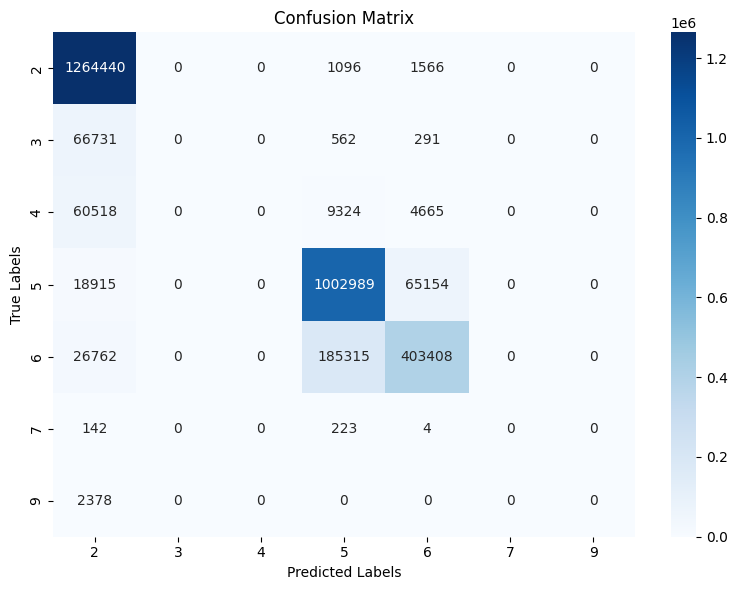

In [27]:
classes = [2, 3, 4, 5, 6, 7, 9]
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

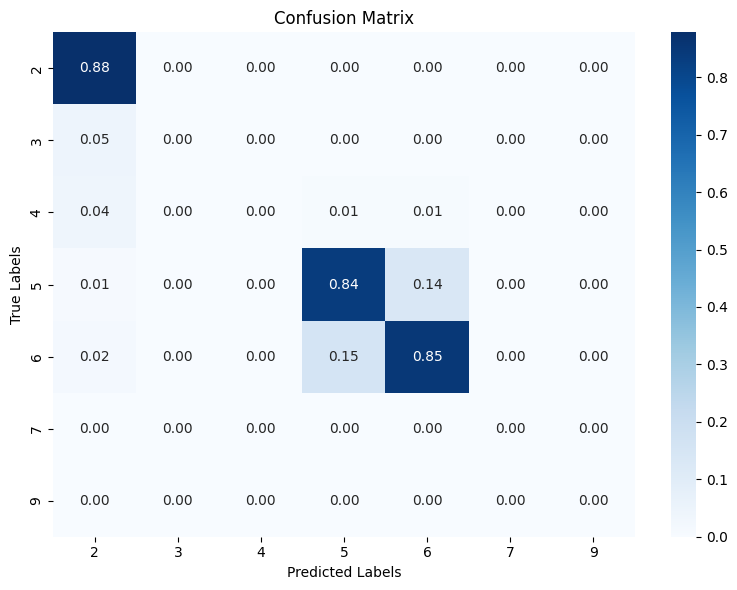

In [28]:
classes = [2, 3, 4, 5, 6, 7, 9]
cm = confusion_matrix(y_test, y_pred, normalize='pred')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Artificial Neural Network (ANN)

In [59]:
X = df.drop(["Classification"], axis=1)
y= df["Classification"]

In [60]:
X = X/X.max()

In [61]:
X

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,ScanAngleRank,PointSourceId,GpsTime
2,0.999048,0.999971,0.691711,0.015656,0.2,0.2,0.0,1.000000,1.000000,0.999996
12,0.999278,0.999975,0.695657,0.008667,0.2,0.2,0.0,1.000000,1.000000,0.999996
16,0.999387,0.999982,0.698582,0.008637,0.4,0.6,1.0,1.000000,1.000000,0.999996
20,0.999325,0.999977,0.693208,0.037842,0.2,0.2,0.0,1.000000,1.000000,0.999996
23,0.999448,0.999983,0.687290,0.002914,0.8,0.8,1.0,0.922935,1.000000,0.999996
...,...,...,...,...,...,...,...,...,...,...
14552270,0.999964,0.999175,0.736097,0.010330,0.4,1.0,0.0,-0.922935,0.480769,1.000000
14552275,0.999964,0.999177,0.722731,0.012680,0.6,0.8,0.0,-0.922935,0.480769,1.000000
14552276,0.999963,0.999176,0.723717,0.013657,0.2,0.2,0.0,-0.922935,0.480769,1.000000
14552280,0.999964,0.999176,0.722833,0.009216,0.4,0.6,0.0,-0.922935,0.480769,1.000000


In [62]:
X = X.to_numpy()

In [63]:
y = to_categorical(y) # One Hot encoding na podanym wektorze, bylo 9 klas to zamienione na macierz o 10 kolumnach

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [65]:
n_features = X.shape[1]
n_classes = y.shape[1]

We create three Dense layers with 128 neurons and a "relu" activation function. Each layer is followed by a dropout of 0.1. The output is a Dense layer with a number of neurons equal to the number of classes and a "softmax" activation function. The model is stopped using an Early Stopping function that takes into account categorical accuracy. The model uses the Adam optimizer with a learning rate of 0.0001.

In [66]:
model = Sequential()
model.add(Dense(128, activation="relu", input_shape=(n_features,)))
model.add(Dropout(0.1)) 
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(n_classes, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer=Adam(0.0001), metrics=["categorical_accuracy"]) 

early_stopping = EarlyStopping(monitor="val_categorical_accuracy", patience=10)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
177845/177845 ━━━━━━━━━━━━━━━━━━━━ 614s 3ms/step - categorical_accuracy: 0.8136 - loss: 0.5306 - val_categorical_accuracy: 0.8790 - val_loss: 0.3366
Epoch 2/100
177845/177845 ━━━━━━━━━━━━━━━━━━━━ 572s 3ms/step - categorical_accuracy: 0.8735 - loss: 0.3506 - val_categorical_accuracy: 0.8818 - val_loss: 0.3251
Epoch 3/100
177845/177845 ━━━━━━━━━━━━━━━━━━━━ 573s 3ms/step - categorical_accuracy: 0.8767 - loss: 0.3394 - val_categorical_accuracy: 0.8826 - val_loss: 0.3199
Epoch 4/100
177845/177845 ━━━━━━━━━━━━━━━━━━━━ 566s 3ms/step - categorical_accuracy: 0.8785 - loss: 0.3334 - val_categorical_accuracy: 0.8849 - val_loss: 0.3129
Epoch 5/100
177845/177845 ━━━━━━━━━━━━━━━━━━━━ 578s 3ms/step - categorical_accuracy: 0.8799 - loss: 0.3290 - val_categorical_accuracy: 0.8878 - val_loss: 0.3030
Epoch 6/100
177845/177845 ━━━━━━━━━━━━━━━━━━━━ 596s 3ms/step - categorical_accuracy: 0.8811 - loss: 0.3254 - val_categorical_accuracy: 0.8877 - val_loss: 0.3049
Epoch 7/100
177845/177845 ━━━━━━━━

In [67]:
model_loss, model_accuracy = model.evaluate(X_test, y_test)
print(f"Loss on the test set: {model_loss:.4f}")
print(f"Categorical accuracy on the test set: {model_accuracy:.4f}")

97328/97328 ━━━━━━━━━━━━━━━━━━━━ 142s 1ms/step - categorical_accuracy: 0.8929 - loss: 0.2889
Loss on the test set: 0.2891
Categorical accuracy on the test set: 0.8928


The graphs below show how loss and categorical accuracy changed over the epochs.

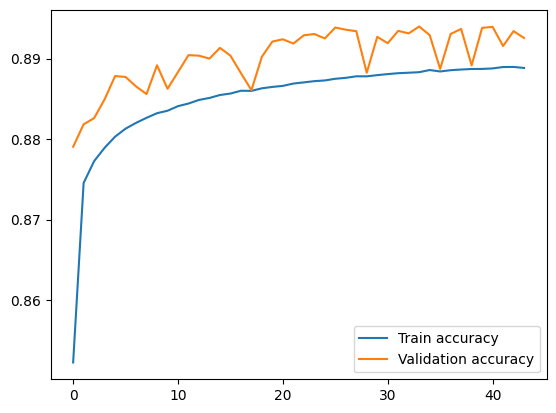

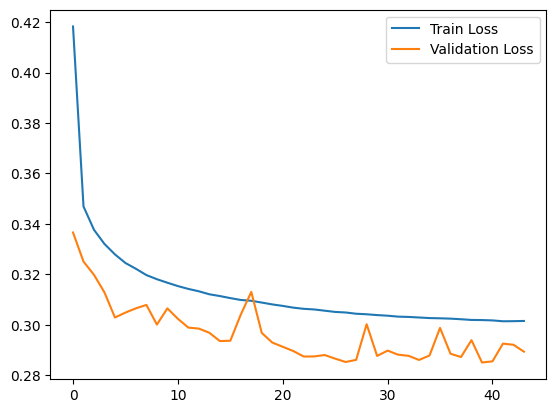

In [68]:
plt.plot(history.history['categorical_accuracy'], label ="Train accuracy")
plt.plot(history.history['val_categorical_accuracy'], label ="Validation accuracy")
plt.legend()
plt.show()
plt.figure()
plt.plot(history.history['loss'], label ="Train Loss")
plt.plot(history.history['val_loss'], label ="Validation Loss")
plt.legend()

In [69]:
y_pred = model.predict(X_test).argmax(1)

97328/97328 ━━━━━━━━━━━━━━━━━━━━ 102s 1ms/step


In [70]:
print(classification_report(y_test.argmax(1), y_pred))

              precision    recall  f1-score   support

           2       0.92      0.99      0.95   1267102
           3       0.51      0.05      0.10     67584
           4       0.61      0.43      0.50     74507
           5       0.88      0.94      0.91   1087058
           6       0.89      0.76      0.82    615485
           7       1.00      0.01      0.02       369
           9       0.68      0.52      0.59      2378

    accuracy                           0.89   3114483
   macro avg       0.78      0.53      0.56   3114483
weighted avg       0.88      0.89      0.88   3114483



In [71]:
print(accuracy_score(y_test.argmax(1), y_pred))

0.892788305474777


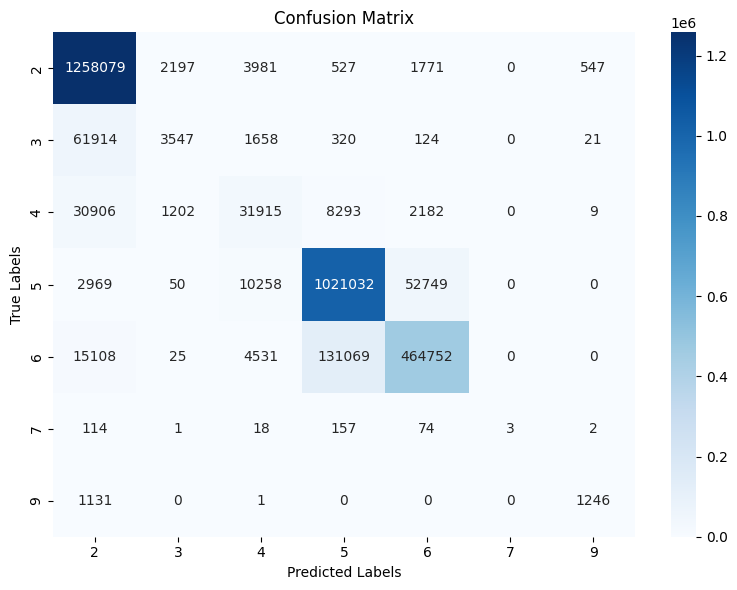

In [72]:
classes = [2, 3, 4, 5, 6, 7, 9]
cm = confusion_matrix(y_test.argmax(1), y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

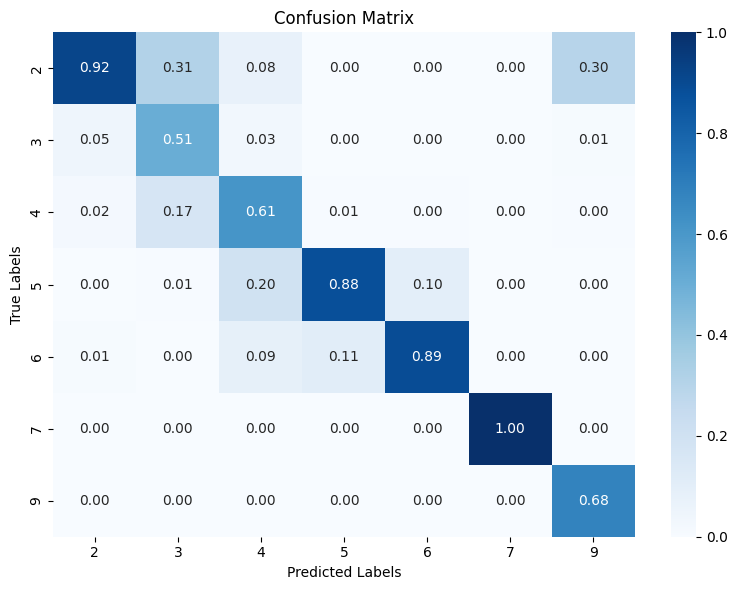

In [73]:
classes = [2, 3, 4, 5, 6, 7, 9]
cm = confusion_matrix(y_test.argmax(1), y_pred, normalize='pred')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Conclusions and summary
The neural network-based model achieved the best results. The following classes were classified best:
- 2 (points lying on the ground)
- 5 (points representing tall vegetation)
- 6 (points representing buildings, structures, and engineering structures)
- 7 (noise)

It is clear that these classes also achieved the best results in the previous models.

The remaining classes performed worse:
- 3 (points representing low vegetation)
- 4 (points representing medium vegetation)
- 9 (points representing water areas)
This is likely due to the fact that these classes are more difficult to recognize based on LIDAR data alone. In some machine learning-based models, these classes were not recognized at all.
Therefore, the neural network-based model clearly has an advantage. It demonstrates the best accuracy, and even difficult-to-recognize classes are classified satisfactorily.